In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd

/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/ix/djishnu/alw399/envs/parrot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [3]:
import sys, os
sys.path.append('../src')

from interaction import Interaction

In [4]:
# CLONAL EXPANSION
name = 'jing_clonal_expansion'
model_name = 'esm2_pca32'
x_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_rna_filtered85.csv'
y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
tcr_embeddings = np.load('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/ESM2_PCA32_KIR+TEDDY.npy')
y = pd.read_csv(y_path)['Y'].values

# # ANTIGEN SPECIFICITY
# name = 'alok_antigen_specificity'
# model_name = 'esm2_pca16'
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# tcr_embeddings = np.load('/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_vecs_beta_ESM2_PCA16.npy')
# y = pd.read_csv(y_path)['Antigen'].values - 1


In [5]:
machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, 
    y=y,
    interacts_only=False,
    model='LR'
)

In [6]:
machop.get_sig_interactions(fdr=0.3, n_iters=20, thresh=0.8)

100%|██████████| 20/20 [06:21<00:00, 19.06s/it]

Found 28 significant interactions with AUC=0.8050207372150096


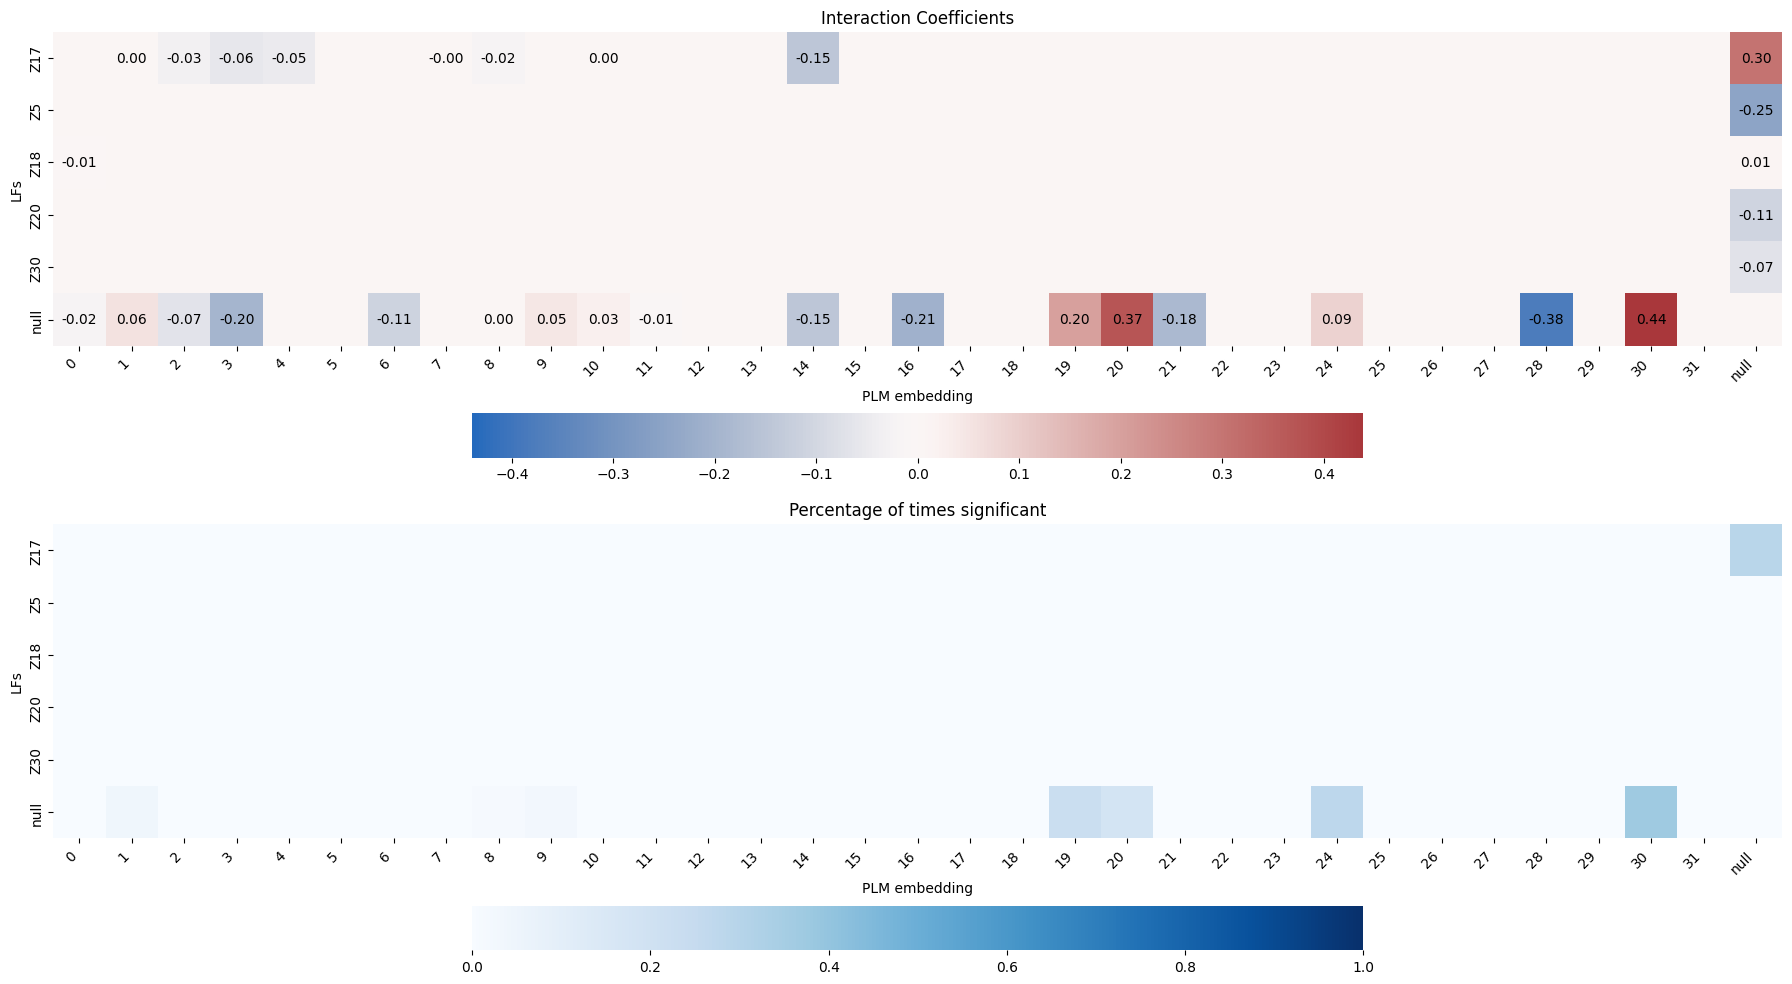

In [7]:
from plotting import show_interactions
show_interactions(machop, save_path=f'../results/interaction/{name}/{model_name}_betas.png')

In [8]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(10191, 28)

In [9]:
np.save(f'../results/interaction/{name}/{model_name}_joint_embed.npy', joint_embed)

In [10]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(10191, 39)

In [11]:
joint_embed.max(), joint_embed.min()

(0.6803287344769504, -0.4823102908421528)

In [12]:
full_embed.max(), full_embed.min()

(2.23645786229341, -2.05381328943911)

In [13]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = Lasso(alpha=0.1)
# model = LinearRegression()


In [14]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)

estimator = Estimator(model=model)
auc1 = estimator.evaluate(full_embed, y)

estimator = Estimator(model=model)
auc2 = estimator.evaluate(machop.z_matrix, y)

estimator = Estimator(model=model)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [15]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01


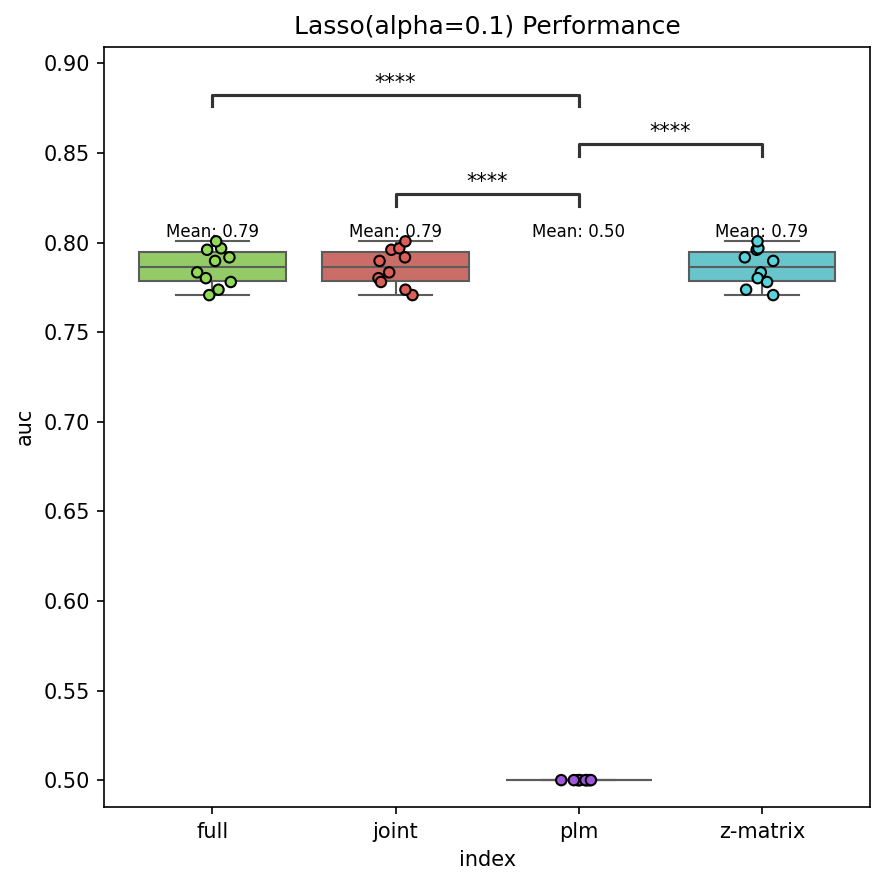

In [16]:
from plotting import show_performance
show_performance(model, df, 
                 save_path=f'../results/interaction/{name}/{model_name}_{model.__class__.__name__}_performance.png')

### Rerun with all Z1sigs and all Z2s

In [17]:
machop.force_linear_terms(z1=True, z2=True)

Found 44 significant interactions with AUC=0.8079082600926953


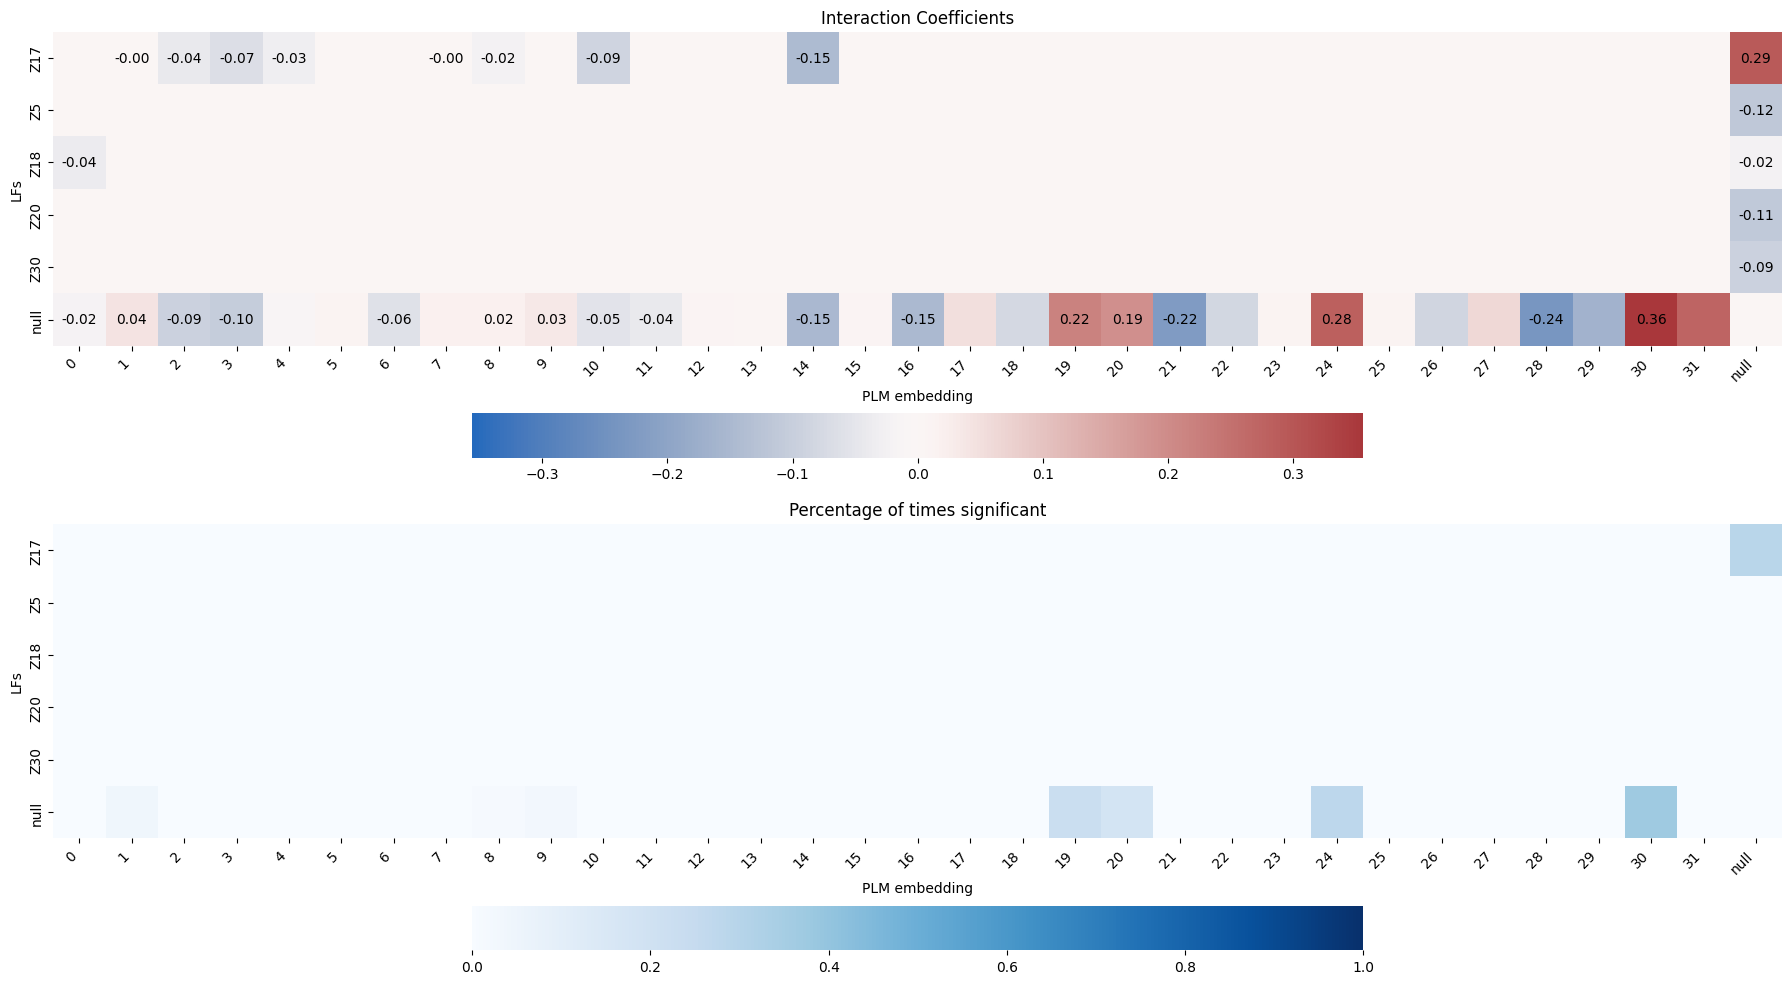

In [18]:
from plotting import show_interactions
show_interactions(machop, save_path=f'../results/interaction/{name}/{model_name}_betas_wlinear.png')

In [19]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(10191, 44)

In [20]:
np.save(f'../results/interaction/{name}/{model_name}_joint_embed_wlinear.npy', joint_embed)

In [21]:
model = Lasso(alpha=0.05)
# model = LinearRegression()

In [22]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)

estimator = Estimator(model=model)
auc1 = estimator.evaluate(full_embed, y)

estimator = Estimator(model=model)
auc2 = estimator.evaluate(machop.z_matrix, y)

estimator = Estimator(model=model)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [23]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

full vs. joint: Kruskal-Wallis independent samples (pairwise between groups), P_val:3.558e-02 Stat=4.417e+00
joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.967e-02 Stat=3.852e+00
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:3.995e-05 Stat=1.687e+01
joint vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:3.472e-03 Stat=8.541e+00
full vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:3.995e-05 Stat=1.687e+01


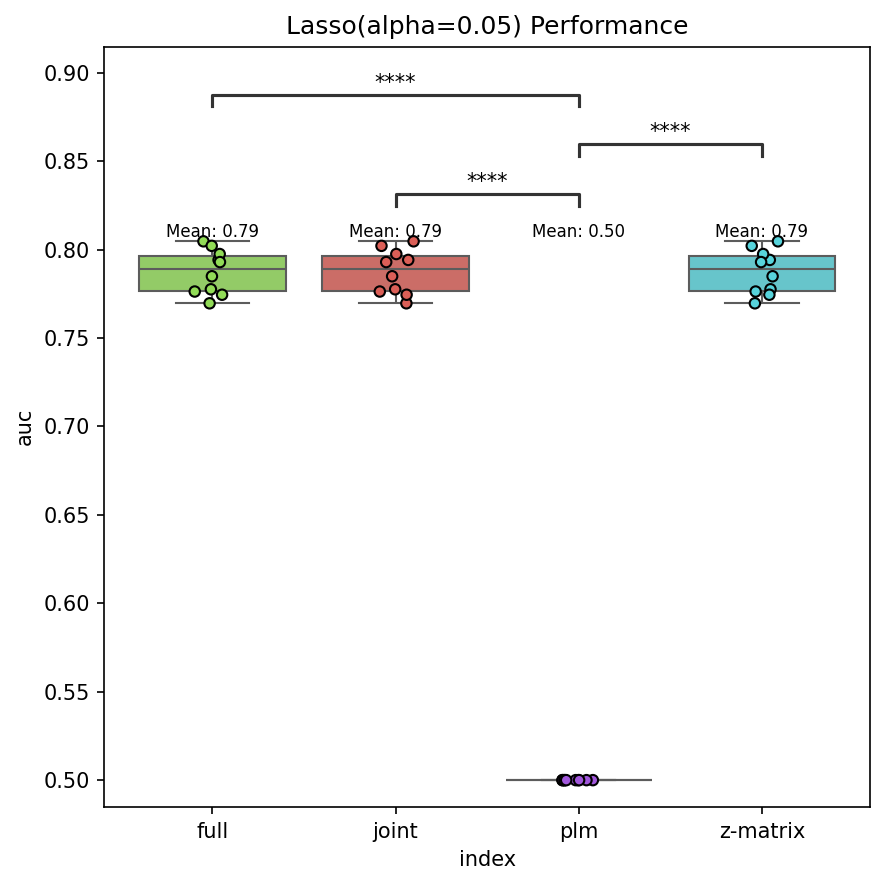

In [24]:
from plotting import show_performance
show_performance(model, df, 
                 save_path=f'../results/interaction/{name}/{model_name}_{model.__class__.__name__}_performance_wlinear.png')